In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.stats import norm

import keras
from keras import backend as K
K.clear_session()

In [2]:
image_shape = (80, 80, 1)  # Adjusted to match your hand gesture images' size and grayscale
batch_size = 64
latent_dim = 16
epochs = 5 

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle  # Import the shuffle function
from tensorflow.keras.utils import to_categorical

# Parameters
IMG_SIZE = 80  # Image size to resize to
data_path = '../input/leapgestrecog/leapGestRecog/'  # Path to dataset folder

# Initialize lists to store images and labels
x_data = []
y_data = []

# Dictionaries for label encoding and decoding
lookup = {}
reverselookup = {}
label_count = 0

# Create label mappings based on subfolders
for folder_name in os.listdir(data_path + '00/'):
    if not folder_name.startswith('.'):
        lookup[folder_name] = label_count
        reverselookup[label_count] = folder_name
        label_count += 1

# Load images and labels
for i in range(10):  # Assumes folders named '00' to '09'
    folder_path = f'{data_path}0{i}/'
    for gesture_folder in os.listdir(folder_path):
        if not gesture_folder.startswith('.'):
            for image_file in os.listdir(f'{folder_path}{gesture_folder}/'):
                # Load and resize each image
                img_path = f'{folder_path}{gesture_folder}/{image_file}'
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                # Check if image is loaded successfully
                if img is None:
                    print(f"Warning: Image {img_path} could not be loaded.")
                    continue

                # Resize and add to dataset
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                x_data.append(img)
                y_data.append(lookup[gesture_folder])

# Convert lists to numpy arrays and normalize
x_data = np.array(x_data, dtype='float32').reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y_data = np.array(y_data)

# One-hot encode labels for classification
y_data = to_categorical(y_data, num_classes=len(lookup))

# Shuffle the dataset
x_data, y_data = shuffle(x_data, y_data, random_state=42)

# Split into training and validation sets (80% train, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Display dataset info
print("Dataset loaded.")
print(f"Total images: {len(x_data)}")
print(f"Image shape: {x_data[0].shape}")
print(f"Number of classes: {len(lookup)}")

# Optional: Check label mappings
print("Label mappings:", lookup)

# Optional: Check the shapes of the train/validation split
print(f"Training set shape: {x_train.shape}, {y_train.shape}")
print(f"Validation set shape: {x_val.shape}, {y_val.shape}")

Dataset loaded.
Total images: 20000
Image shape: (80, 80, 1)
Number of classes: 10
Label mappings: {'02_l': 0, '04_fist_moved': 1, '09_c': 2, '10_down': 3, '06_index': 4, '08_palm_moved': 5, '07_ok': 6, '05_thumb': 7, '01_palm': 8, '03_fist': 9}
Training set shape: (16000, 80, 80, 1), (16000, 10)
Validation set shape: (4000, 80, 80, 1), (4000, 10)


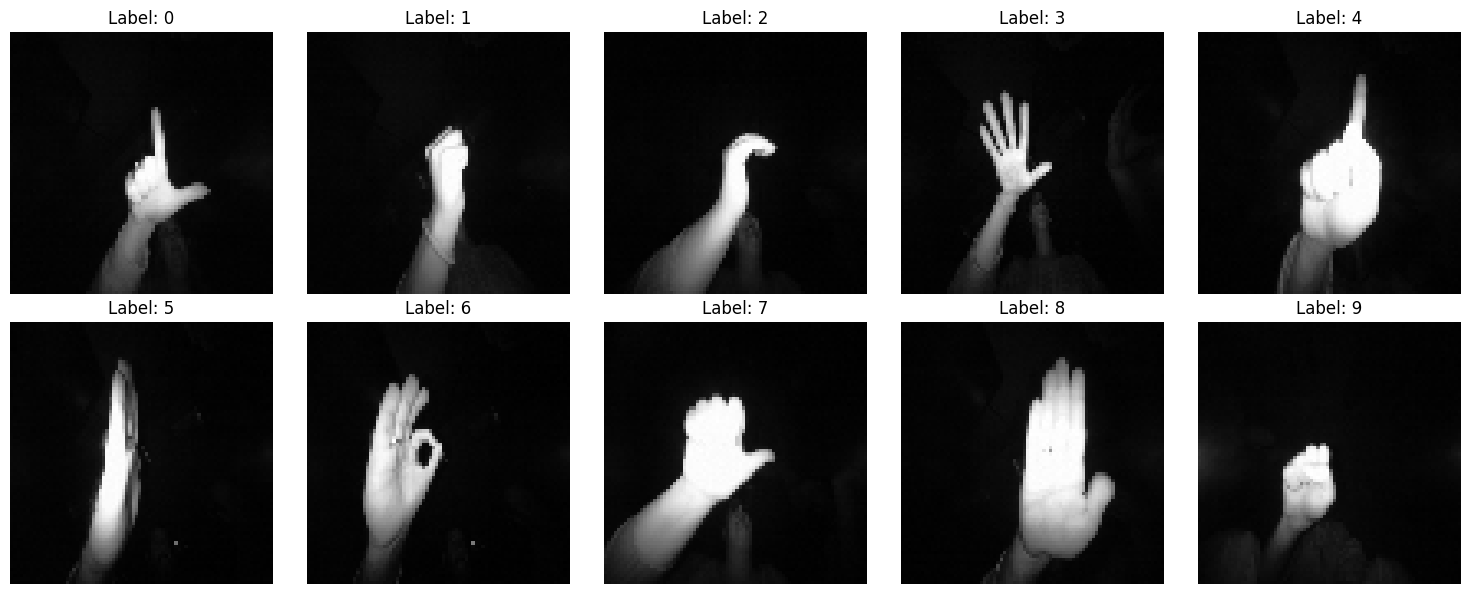

In [4]:
import random

def get_images_1_to_10(x_data, y_data):
    # Initialize empty lists to store selected images and labels
    selected_images = []
    selected_labels = []

    # Loop through labels 0 to 9
    for label in range(10):
        # Get indices where the label is equal to the current label
        label_indices = [i for i, lbl in enumerate(y_data) if np.argmax(lbl) == label]
        
        # Randomly select one image from the indices of that label
        selected_index = random.choice(label_indices)
        
        # Append the image and its label to the selected lists
        selected_images.append(x_data[selected_index])
        selected_labels.append(label)

    return np.array(selected_images), np.array(selected_labels)

# Select random 10 images of labeled 0 to 9
selected_x, selected_y = get_images_1_to_10(x_train, y_train)

# To visualize the selected images, you can use matplotlib
import matplotlib.pyplot as plt

# Display the selected images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, img, label in zip(axes.ravel(), selected_x, selected_y):
    ax.imshow(img.reshape(image_shape[0], image_shape[1]), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()


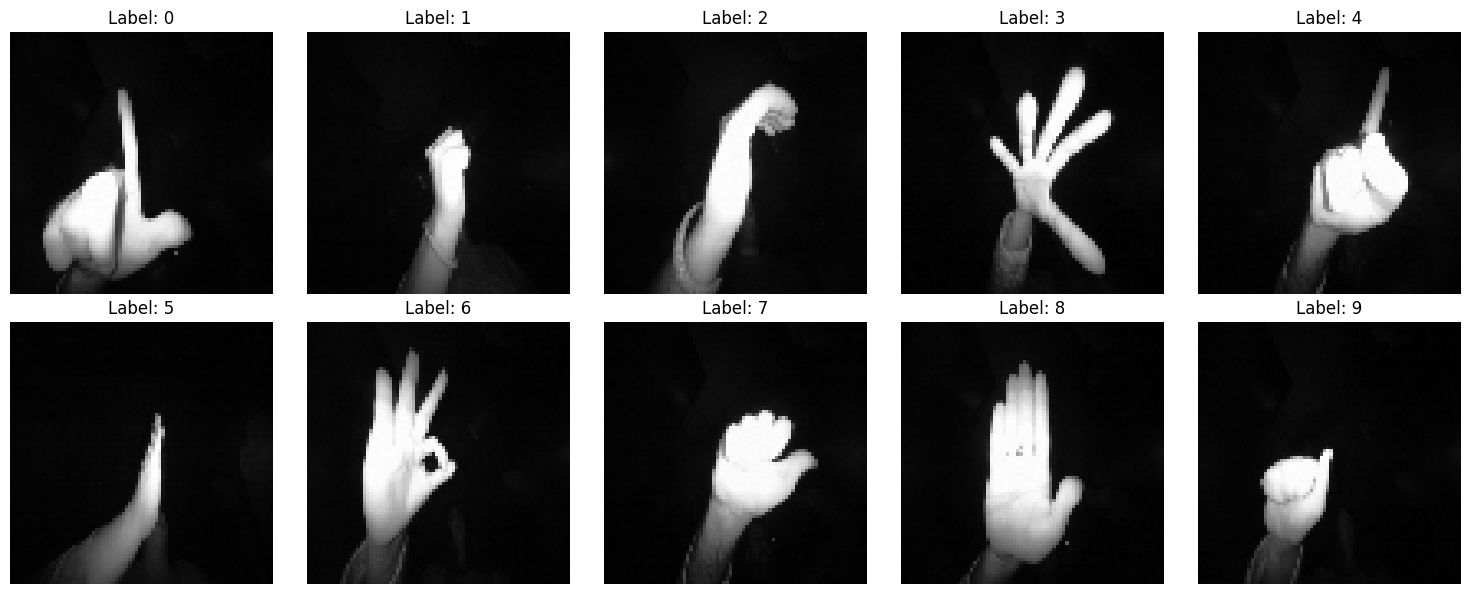

In [5]:
# Select random 10 images of labeled 0 to 9
selected_x, selected_y = get_images_1_to_10(x_train, y_train)

# To visualize the selected images, you can use matplotlib
import matplotlib.pyplot as plt

# Display the selected images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, img, label in zip(axes.ravel(), selected_x, selected_y):
    ax.imshow(img.reshape(image_shape[0], image_shape[1]), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN model architecture
model = Sequential()

# Add Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the last pooling layer
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

model.add(Dense(len(lookup), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 78, 78, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,666 (4.36 MB)

 Trainable params: 1,142,666 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the CNN model
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_val, y_val),
    verbose=2
)

# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(x_val, y_val, verbose=2)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Epoch 1/5
250/250 - 93s - 373ms/step - accuracy: 0.8429 - loss: 0.4649 - val_accuracy: 0.9970 - val_loss: 0.0093
Epoch 2/5
250/250 - 92s - 367ms/step - accuracy: 0.9846 - loss: 0.0464 - val_accuracy: 0.9995 - val_loss: 0.0018
Epoch 3/5
250/250 - 91s - 364ms/step - accuracy: 0.9915 - loss: 0.0267 - val_accuracy: 0.9998 - val_loss: 0.0010
Epoch 4/5
250/250 - 90s - 362ms/step - accuracy: 0.9937 - loss: 0.0210 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 5/5
250/250 - 141s - 566ms/step - accuracy: 0.9942 - loss: 0.0160 - val_accuracy: 0.9995 - val_loss: 0.0031
125/125 - 5s - 44ms/step - accuracy: 0.9995 - loss: 0.0031
Validation Accuracy: 99.95%


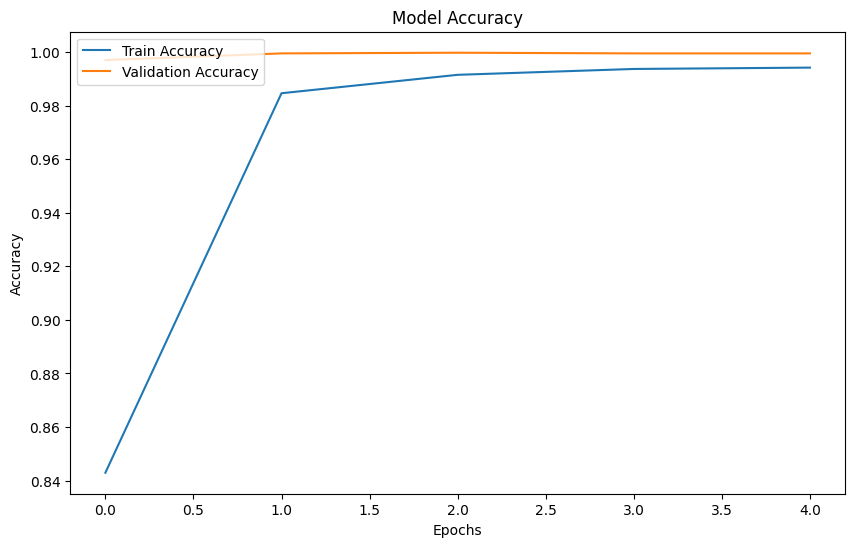

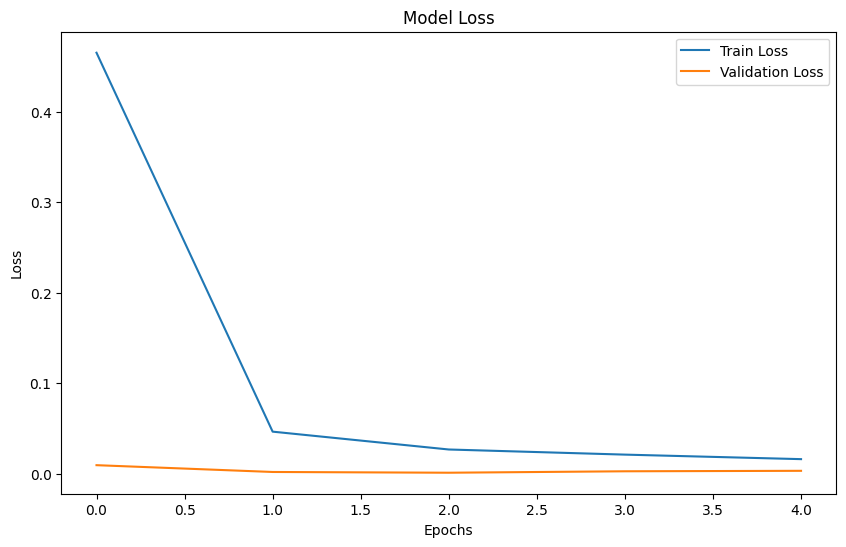

In [8]:
import matplotlib.pyplot as plt

# Plot the training & validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot the training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


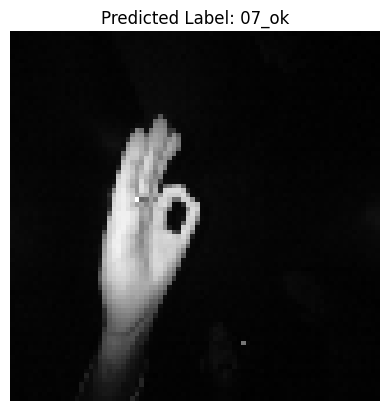

In [9]:
# Example: Predict on a random image from the validation set
import random

# Select a random image from the validation set
random_idx = random.randint(0, len(x_val) - 1)
img = x_val[random_idx].reshape(1, IMG_SIZE, IMG_SIZE, 1)

# Predict the class of the image
prediction = model.predict(img)
predicted_class = np.argmax(prediction)

# Get the label name using reverse lookup
predicted_label = reverselookup[predicted_class]

# Display the predicted label and the image
plt.imshow(x_val[random_idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()


In [10]:
# Save the model to a file
model.save('hand_gesture_cnn_model.h5')

# Load the saved model
from tensorflow.keras.models import load_model
loaded_model = load_model('hand_gesture_cnn_model.h5')

# Verify the model is loaded successfully
loaded_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 78, 78, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,668 (4.36 MB)

 Trainable params: 1,142,666 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)